# Notebook comparing the performance of BiLSTM and Transformer Encoder for NER in Malayalam.

- Uses the malayalam subset of [ai4bharat/naamapadam](https://huggingface.co/datasets/ai4bharat/naamapadam/viewer/ml/train)

- This notebook was used to define and train a 3 layer BiLSTM as well as a 2 layer transformer encoder.

- Uses BPE tokenizer from https://bpemb.h-its.org/

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
!pip install wandb datasets torchmetrics bpemb pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [4]:
from torchmetrics import F1Score

In [5]:
from datasets import load_dataset

In [15]:
indic_ner_data = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [16]:
indic_ner_data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [17]:
def __extract_non_zero(x, cutoff):
  ## Was used to extract out sentences with only 0 tags.
  count = 0
  for i in x:
    if i != 0:
      count += 1
  return count > cutoff

In [18]:
def __extract_non_zero_percentage(x, cutoff):
  ## was used for the same purpose by above but using a percentage crietria to accout for thr length info
  ## NOTE: This was not used in the final model.
  count = 0
  for i in x:
    if i != 0:
      count += 1
  return (count / len(x)) > cutoff

### Getting Train, Valid, & Test Data

In [19]:
ds_train = list(filter(lambda x: __extract_non_zero(x['ner_tags'], 0), indic_ner_data['train']))
ds_val = indic_ner_data['validation']
ds_test = indic_ner_data['test']

In [20]:
ids_to_tags = {
    0 : 'O',
    1 : 'B-PER',
    2 : 'I-PER',
    3 : 'B-ORG',
    4 : 'I-ORG',
    5 : 'B-LOC',
    6 : 'I-LOC'
}

Visualizing the distribution of tags in the dataset.

In [21]:
import matplotlib.pyplot as plt

In [22]:
def visualize_tag_distribution(split):
  res = []
  for pair in split:
    res.extend(pair['ner_tags'])
  plt.hist(res)

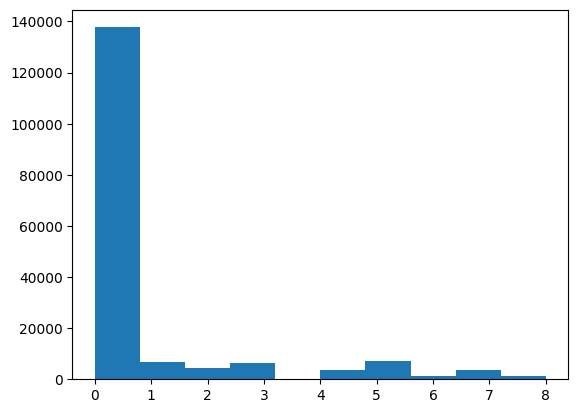

In [23]:
visualize_tag_distribution(ds_train)

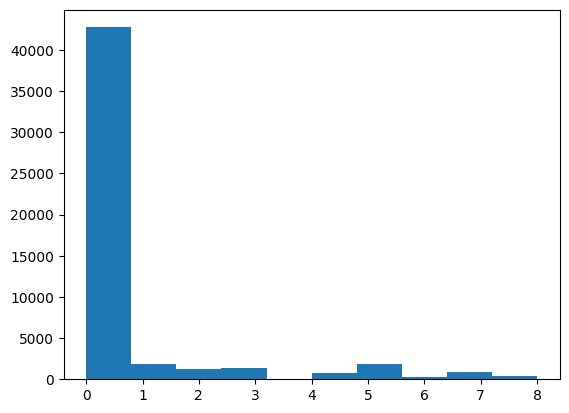

In [24]:
visualize_tag_distribution(ds_val)

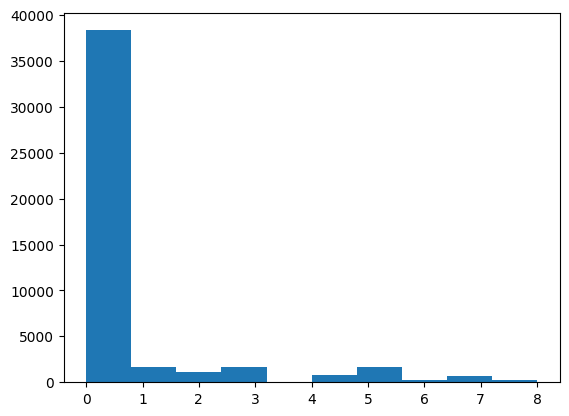

In [25]:
visualize_tag_distribution(ds_test)

We've got similar distribution accross our train, validation and test splits. We can also see that 0 (Other) tag dominates accross the three splits. Whereas, 6 is in the minority accros the three splits.

## Preprocessing

In [26]:
import string
import unicodedata

def remove_unicode_control_chars(text):
    """Remove all Unicode control characters from a string."""
    cleaned_text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    return cleaned_text

### BPE Tokenizer

In [27]:
from bpemb import BPEmb

In [28]:
bpemb_ml = BPEmb(lang='eng', add_pad_emb=True)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 11035702.00B/s]

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d100.w2v.bin.tar.gz



100%|██████████| 3784656/3784656 [00:00<00:00, 48940952.06B/s]


In [29]:
bpemb_ml.encode_ids_with_bos_eos('who let the dog out')

[1, 305, 2307, 7, 3257, 371, 2]

In [30]:
bpemb_ml.encode_ids_with_bos_eos('hi there, i am a researcher')

[1, 40, 9916, 351, 9934, 386, 425, 4, 5616, 1924, 2]

In [31]:
bpemb_ml

BPEmb(lang=en, vs=10000, dim=100)

### Torch Dataset

In [32]:
len(ds_train), len(ds_val), len(ds_test)

(11132, 3250, 3453)

In [33]:
from torch.utils.data import Dataset, DataLoader

In [41]:
class MalayalamNERDataset(Dataset):
    def __init__(self, split, tokenizer: BPEmb, crfs: bool=False):
        self.split = split
        self.tokenizer = tokenizer
        self.max_token_len = self._get_max_token_len()
        self.crfs = crfs

    def __len__(self):
        return len(self.split)

    def _get_max_token_len(self):
        max_len = 100
        # for i in range(len(self.split)):
        #     max_len = max(max_len, len(self.tokenizer.encode(self.split[i]['tokens'])))
        # print(max_len)
        return max_len

    def _align_labels(self, tokens, ner_tags):
        inter_tokens = self.tokenizer.encode(tokens)
        current_tag = None
        ner = -1
        labels = []
        for token in inter_tokens:
            if token[0] == '▁':
                ner += 1
                current_tag = ner_tags[ner]
                labels.append(current_tag)
            else:
                labels.append(current_tag)
        return [0] + labels + [0]

    def _pad_tokens_and_tags_get_mask(self, tokens: str, ner_tags):
        tokens: list[str] = self.tokenizer.encode_ids_with_bos_eos(tokens)
        padding_len: int = self.max_token_len - len(tokens)
        ner_tags = torch.tensor(ner_tags, dtype=torch.int64)
        if padding_len < 0:
            tokens = tokens[:self.max_token_len - 1]
            tokens = tokens + [self.tokenizer.EOS]
            tokens = torch.tensor(tokens, dtype=torch.int64)
            ner_tags = ner_tags[:self.max_token_len]
        else:
            padding_vectors = torch.zeros(padding_len) - 1
            tokens = torch.tensor(tokens, dtype=torch.int64)
            tokens = torch.cat([tokens, padding_vectors], axis=0)
            ner_tags = torch.cat([ner_tags, torch.zeros(padding_len)], axis=0).long()
        if not self.crfs:
          ner_tags = F.one_hot(ner_tags, num_classes=9)
        mask = tokens > 0
        tokens[~mask] = 0
        return tokens, mask, ner_tags

    def __getitem__(self, idx):
        tokens = " ".join(self.split[idx]['tokens'])
        tokens = remove_unicode_control_chars(tokens)
        tokens = tokens.translate(str.maketrans('', '', string.punctuation))
        tokens = " ".join(tokens.split())
        ner_tags = self.split[idx]['ner_tags']
        ner_tags = self._align_labels(tokens, ner_tags)
        tokens, mask, ner_tags = self._pad_tokens_and_tags_get_mask(tokens, ner_tags)
        ner_tags = ner_tags.float() if not self.crfs else ner_tags.long()
        mask = mask.long() if not self.crfs else mask.bool()
        return tokens.long(), ner_tags, mask

In [42]:
tokens, ner_tags, mask = MalayalamNERDataset(indic_ner_data['train'], bpemb_ml, crfs=True)[300]
ner_tags

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0, 7, 7, 7, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [43]:
train_dataset = MalayalamNERDataset(split=indic_ner_data['train'], tokenizer=bpemb_ml, crfs=False)
val_dataset = MalayalamNERDataset(split=indic_ner_data['validation'], tokenizer=bpemb_ml, crfs=False)
test_dataset = MalayalamNERDataset(split=indic_ner_data['test'], tokenizer=bpemb_ml, crfs=False)

In [44]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=256, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=0)

In [45]:
tokens, ner_tags, mask = next(iter(train_dataloader))


In [ ]:
ner_tags[0]

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.,

### Modelling BiLSTM

In [139]:
class BiLSTM_MAL(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, nonlinearity, bias, dropout, bidirectional=False, batch_first=True, num_classes=9):
        super(BiLSTM_MAL, self).__init__()
        self.emb_layer = nn.Embedding.from_pretrained(torch.tensor(bpemb_ml.vectors))
        self.emb_layer.weight.requires_grad = False
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            # nonlinearity=nonlinearity,
            bias=bias,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=batch_first
        )
        self.bc = nn.LayerNorm(hidden_size * 2)
        self.first_bc = nn.LayerNorm(100)
        self.linear = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, num_classes)
        )
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
          if "weight_ih" in name:
              nn.init.xavier_uniform_(param)
          elif "weight_hh" in name:
              nn.init.orthogonal_(param)
          elif "bias" in name:
              nn.init.constant_(param, 0)

    def forward(self, tokens, mask):
        embeddings = self.emb_layer(tokens)
        embeddings = self.first_bc(embeddings)
        # print(embeddings)
        rnn_output, _ = self.rnn(embeddings)
        # rnn_output = rnn_output @ mask
        rnn_output = self.bc(rnn_output)
        linear_output = self.linear(rnn_output)
        return linear_output


In [140]:
bi_lstm = BiLSTM_MAL(
    input_size=100,
    hidden_size=200,
    num_layers=3,
    dropout=0.3,
    nonlinearity='relu',
    bias=True,
    bidirectional=True
)

Sanity Checking BiLSTM

In [141]:
t_iter = iter(train_dataloader)
data = next(t_iter)

In [142]:
res = bi_lstm(data[0], data[2])

In [143]:
res

tensor([[[ 0.1287,  0.1931,  0.3556,  ...,  0.1059, -0.0756, -0.1330],
         [ 0.2147,  0.2332,  0.2483,  ...,  0.1296, -0.1142, -0.1202],
         [ 0.0363,  0.2776,  0.3926,  ...,  0.0477, -0.1105, -0.0390],
         ...,
         [-0.0542,  0.0730,  0.0953,  ...,  0.1691, -0.2532,  0.2872],
         [-0.0319,  0.1032,  0.1782,  ...,  0.3258, -0.1823,  0.2665],
         [-0.1521,  0.1115,  0.1506,  ...,  0.2864, -0.2463,  0.2345]],

        [[-0.2005,  0.1466,  0.5846,  ...,  0.4031, -0.0815,  0.1482],
         [-0.0064, -0.0308,  0.3979,  ...,  0.3267, -0.1220,  0.0657],
         [ 0.1822, -0.0661,  0.2779,  ...,  0.1377, -0.0416,  0.0960],
         ...,
         [-0.0319,  0.2296,  0.1062,  ...,  0.1120, -0.1714,  0.3628],
         [-0.1897,  0.0304,  0.0400,  ...,  0.1116, -0.2616,  0.3313],
         [-0.2578,  0.0623,  0.0173,  ...,  0.3352, -0.1421,  0.2751]],

        [[ 0.3278,  0.2096,  0.3021,  ..., -0.0952,  0.1538,  0.3355],
         [ 0.3215,  0.1401,  0.2417,  ..., -0

In [144]:
res.shape

torch.Size([256, 100, 9])

BiLSTM Pytorch Lightning

In [145]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

In [146]:
wand = WandbLogger(name='NER-TENER-FUll-DATA_CLEANED', log_model=True)

In [147]:
wandb.finish()

In [148]:
import wandb

In [149]:
from torchmetrics import ConfusionMatrix

In [150]:
f1 = F1Score(task="multiclass", num_classes=9).to('cuda' if torch.cuda.is_available() else 'cpu')
confmat = ConfusionMatrix(task="multiclass", num_classes=9)

In [202]:
class BiLSTMLightning(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(output.size(0), output.size(1), -1)
        ner_tags_reshaped = ner_tags.view(ner_tags.size(0), ner_tags.size(1), -1)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.2, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 9.0] * (100 // 9) + [9.0] * (100 % 9)).to('cuda' if torch.cuda.is_available() else 'cpu'))
        self.log('train_loss', loss)
        #self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        #output_reshaped = output.view(-1,9)
        #ner_tags_reshaped = ner_tags.view(-1,9)
        output_reshaped = output.view(output.size(0), output.size(1), -1)
        ner_tags_reshaped = ner_tags.view(ner_tags.size(0), ner_tags.size(1), -1)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.2, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 9.0] * (100 // 9) + [9.0] * (100 % 9)).to('cuda' if torch.cuda.is_available() else 'cpu'))
        #self.log('train_loss', loss)
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(output.size(0), output.size(1), -1)
        ner_tags_reshaped = ner_tags.view(ner_tags.size(0), ner_tags.size(1), -1)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped)
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('test_loss', loss)
        conf_matrix = wandb.plot.confusion_matrix(probs=None, y_true=original_tags.cpu().numpy(), preds=output_tags.cpu().numpy(), class_names=list(range(9)))
        self.logger.experiment.log({"confusion_matrix": conf_matrix})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.model.parameters(), lr=0.01)
import torch


In [203]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [204]:
early_stopping_callbacks = EarlyStopping(monitor="train_loss", mode="min")
model_checkpoint_callbacks = ModelCheckpoint(filename='best_model', monitor='val_loss', mode='min')

In [205]:
trainer = pl.Trainer(logger=wand, min_epochs=5, max_epochs=20, accelerator='gpu', gradient_clip_val=1.0,callbacks=[early_stopping_callbacks, model_checkpoint_callbacks])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [206]:
bi_lstm_pl = BiLSTMLightning(bi_lstm)

In [207]:
trainer.fit(model=bi_lstm_pl, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | BiLSTM_MAL | 3.5 M 
-------------------------------------
2.5 M     Trainable params
1.0 M     Non-trainable params
3.5 M     Total params
13.971    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Detected more unique values in `target` than `num_classes`. Expected only 9 but found 35 in `target`.

In [85]:
trainer.test(dataloaders=test_dataloader, model=bi_lstm_pl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

RuntimeError: shape '[-1, 7]' is invalid for input of size 28800

### Modelling TENER (Transformer Encoder for NER, Link: https://arxiv.org/pdf/1911.04474v3.pdf)

Some differences from the paper:
- I've decided to use the same positional embeddings as vanilla transformers
- I have dropped the CRF layer, as it was leading to some instability during training, got to work out why that is.
- Since there is severe imbalance in the data, I've weighed the loss of each class in the cross entropy loss.
- I've taken d_model = 512 and n_head = 16

In [46]:
import math

In [209]:
class MultiHeadAttn(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1, scale=False):
        super().__init__()
        assert d_model%n_head==0

        self.n_head = n_head
        self.qkv_linear = nn.Linear(d_model, 3*d_model, bias=False)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout_layer = nn.Dropout(dropout)

        if scale:
            self.scale = math.sqrt(d_model//n_head)
        else:
            self.scale = 1

    def forward(self, x, mask):
        batch_size, max_len, d_model = x.size()
        x = self.qkv_linear(x)
        q, k, v = torch.chunk(x, 3, dim=-1)
        q = q.view(batch_size, max_len, self.n_head, -1).transpose(1, 2)
        k = k.view(batch_size, max_len, self.n_head, -1).permute(0, 2, 3, 1)
        v = v.view(batch_size, max_len, self.n_head, -1).transpose(1, 2)

        attn = torch.matmul(q, k)  # batch_size x n_head x max_len x max_len
        attn = attn/self.scale
        attn.masked_fill_(mask=mask[:, None, None].eq(0), value=float('-inf'))

        attn = F.softmax(attn, dim=-1)  # batch_size x n_head x max_len x max_len
        attn = self.dropout_layer(attn)
        v = torch.matmul(attn, v)  # batch_size x n_head x max_len x d_model//n_head
        v = v.transpose(1, 2).reshape(batch_size, max_len, -1)
        v = self.fc(v)

        return v

In [210]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, self_attn, feedforward_dim, after_norm, dropout):
        super().__init__()

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.self_attn = self_attn

        self.after_norm = after_norm

        self.ffn = nn.Sequential(nn.Linear(d_model, feedforward_dim),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(feedforward_dim, d_model),
                                 nn.Dropout(dropout))

    def forward(self, x, mask):
        residual = x
        if not self.after_norm:
            x = self.norm1(x)

        x = self.self_attn(x, mask)
        x = x + residual
        if self.after_norm:
            x = self.norm1(x)
        residual = x
        if not self.after_norm:
            x = self.norm2(x)
        x = self.ffn(x)
        x = residual + x
        if self.after_norm:
            x = self.norm2(x)
        return x

In [211]:
def make_positions(tensor, padding_idx):
    """Replace non-padding symbols with their position numbers.
    Position numbers begin at padding_idx+1. Padding symbols are ignored.
    """
    # The series of casts and type-conversions here are carefully
    # balanced to both work with ONNX export and XLA. In particular XLA
    # prefers ints, cumsum defaults to output longs, and ONNX doesn't know
    # how to handle the dtype kwarg in cumsum.
    mask = tensor.ne(padding_idx).int()
    return (
        torch.cumsum(mask, dim=1).type_as(mask) * mask
    ).long() + padding_idx


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(0).unsqueeze(-1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len,d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [212]:
from copy import deepcopy

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, n_head, feedforward_dim, dropout, after_norm=True, attn_type='transformer',
                 scale=False, dropout_attn=None, pos_embed=None):
        super().__init__()
        if dropout_attn is None:
            dropout_attn = dropout
        self.d_model = d_model
        self.pos_embed = PositionalEncoding(d_model, max_len=100) if pos_embed else None
        self_attn = MultiHeadAttn(d_model, n_head, dropout_attn, scale=scale)
        self.layers = nn.ModuleList([TransformerLayer(d_model, deepcopy(self_attn), feedforward_dim, after_norm, dropout)
                       for _ in range(num_layers)])

    def forward(self, x, mask):
        if self.pos_embed is not None:
            res = self.pos_embed(x)
            x = x + res
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [217]:
class TENER(nn.Module):
  def __init__(self, d_model):
    super(TENER, self).__init__()
    self.in_fc = nn.Linear(100, d_model)
    self.transformer = TransformerEncoder(num_layers=2, d_model=512, n_head=16, feedforward_dim=512*2, dropout=0.3, pos_embed='mine', scale=True)
    self.fc_dropout = nn.Dropout(0.3)
    self.out_fc = nn.Linear(d_model, 9)
    self.emb_layer = nn.Embedding.from_pretrained(torch.tensor(bpemb_ml.vectors))
    self.emb_layer.weight.requires_grad = False

  def forward(self, tokens, mask):
    tokens = self.emb_layer(tokens)
    tokens = self.in_fc(tokens)
    tokens = self.transformer(tokens, mask)
    tokens = self.fc_dropout(tokens)
    tokens = self.out_fc(tokens)
    return tokens

In [218]:
tener_ml = TENER(512)

In [219]:
t_iter = iter(train_dataloader)
data = next(t_iter)

In [220]:
tener_ml(data[0], data[2]).shape

torch.Size([256, 100, 9])

In [228]:
class TENER_MAL(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 9)
        ner_tags_reshaped = ner_tags.view(-1, 9)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.5, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 9)
        ner_tags_reshaped = ner_tags.view(-1, 9)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.5, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 9)
        ner_tags_reshaped = ner_tags.view(-1, 9)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped)
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('test_loss', loss)
        conf_matrix = wandb.plot.confusion_matrix(probs=None, y_true=original_tags.cpu().numpy(), preds=output_tags.cpu().numpy(), class_names=list(range(9)))
        self.logger.experiment.log({"confusion_matrix": conf_matrix})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.model.parameters(), lr=0.0001)

In [229]:
trainer = pl.Trainer(logger=wand, min_epochs=5, max_epochs=20, accelerator='gpu', gradient_clip_val=1.0,callbacks=[early_stopping_callbacks, model_checkpoint_callbacks])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [230]:
tener_mal = TENER_MAL(tener_ml)

In [261]:
#trainer.fit(model=tener_mal, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.fit(model=tener_mal, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./lightning_logs/d0xob38a/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | TENER | 5.3 M 
--------------------------------
4.3 M     Trainable params
1.0 M     Non-trainable params
5.3 M     Total params
21.036    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


In [232]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9650998115539551     │
│         test_loss         │    0.10367874801158905    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9650998115539551, 'test_loss': 0.10367874801158905}]

In [233]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9650998711585999     │
│         test_loss         │    0.10367874801158905    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9650998711585999, 'test_loss': 0.10367874801158905}]

In [234]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9650998711585999     │
│         test_loss         │    0.10367874801158905    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9650998711585999, 'test_loss': 0.10367874801158905}]

In [235]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9650998711585999     │
│         test_loss         │    0.10367874801158905    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9650998711585999, 'test_loss': 0.10367874801158905}]

In [236]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9650998711585999     │
│         test_loss         │    0.10367874801158905    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9650998711585999, 'test_loss': 0.10367874801158905}]

## Inference

In [237]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [238]:
## Remove punctuations
## Remove unicode control characters

import string, unicodedata

def remove_punctuation(input_string: str) -> str:
    return input_string.translate(str.maketrans('', '', string.punctuation))

def remove_unicode_control_characters(input_string: str) -> str:
    return ''.join(char for char in input_string if not unicodedata.category(char).startswith('C'))

def inference_preprocess(input_string: str) -> str:
    input_string = remove_punctuation(input_string)
    input_string = remove_unicode_control_characters(input_string)
    return " ".join(input_string.split())

In [239]:
def get_tokens_and_masks(input_string, bpemb):
    tokens = bpemb.encode_ids_with_bos_eos(input_string)
    padding_len = 100 - len(tokens)
    if padding_len < 0:
        tokens = tokens[:99]
        tokens = tokens + [bpemb.EOS]
        tokens = torch.tensor(tokens, dtype=torch.int64)
    else:
        padding_vectors = torch.zeros(padding_len) - 1
        tokens = torch.tensor(tokens, dtype=torch.int64)
        tokens = torch.cat([tokens, padding_vectors], axis=0)
    mask = tokens > 0
    tokens[~mask] = 0
    return tokens.long().unsqueeze(0), mask.long().unsqueeze(0)

In [245]:
def predict(model, input_string, encoder):
    # returns a list of tuples of the form:
    # (token, tag, confidence_score)
    input_string = inference_preprocess(input_string)
    tokens, mask = get_tokens_and_masks(input_string, encoder)
    tokens = tokens.to(DEVICE)
    mask = mask.to(DEVICE)
    model = model.to(DEVICE)
    with torch.no_grad():
        op = model(tokens, mask)
    softmaxed = torch.softmax(op, dim=-1)[mask == 1]
    conf_scores = torch.max(softmaxed, dim=-1)
    conf_scores = list(map(lambda x: x.item(), conf_scores[0]))
    argmaxed = torch.argmax(op, dim=-1)[mask == 1]
    tags = [ids_to_tags[i.item()] for i in argmaxed]
    return list(zip(encoder.encode_with_bos_eos(input_string), tags, conf_scores))

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [284]:
tener_ml = TENER(512)
tener_mal_inference = TENER_MAL(model=tener_ml)
#tener_mal_inference.load_state_dict(torch.load(PATH_TO_TENER_WEIGHTS, map_location=torch.device(DEVICE))['state_dict'])
#torch.save(tener_mal_inference.state_dict(), PATH_TO_TENER_WEIGHTS)
torch.save(tener_mal_inference, 'tensor.ckpt')

#### BiLSTM

In [269]:
predict(
    bi_lstm_inference.model,
    "വര്‍ഷങ്ങൾക്ക് മുമ്പ് മണിയൻ പിള്ള രാജുവും കൊച്ചിൻ ഹനീഫയും സിനിമയിൽ അവസരം തേടി നടക്കുന്ന സമയം.",
    bpemb_ml
)

KeyError: 7

### TENER-MALAYALAM

In [285]:
predict(
    tener_mal_inference.model,
    "Rabinovich is winding uphis term as ambassador",
    bpemb_ml
)

[('<s>', 'I-ORG', 0.44512978196144104),
 ('▁r', 'B-PER', 0.2619670331478119),
 ('ab', 'I-LOC', 0.22468453645706177),
 ('in', 'I-LOC', 0.29362621903419495),
 ('ov', 'B-ORG', 0.23029819130897522),
 ('ich', 'I-PER', 0.3228403925895691),
 ('▁is', 'B-ORG', 0.29865580797195435),
 ('▁w', 'I-LOC', 0.23004625737667084),
 ('ind', 'B-LOC', 0.21695104241371155),
 ('ing', 'I-PER', 0.2151186615228653),
 ('▁up', 'I-LOC', 0.3661629855632782),
 ('h', 'I-LOC', 0.21336781978607178),
 ('is', 'B-LOC', 0.2279939502477646),
 ('▁ter', 'I-LOC', 0.2899785041809082),
 ('m', 'I-LOC', 0.31559064984321594),
 ('▁as', 'I-ORG', 0.2802184820175171),
 ('▁am', 'I-ORG', 0.557680606842041),
 ('b', 'I-ORG', 0.3501405119895935),
 ('ass', 'B-LOC', 0.26401224732398987),
 ('ad', 'I-ORG', 0.356277197599411),
 ('or', 'I-ORG', 0.24051590263843536),
 ('</s>', 'B-ORG', 0.2770718038082123)]